In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io import loadmat
from numpy.linalg import lstsq
from scipy.stats import t

# Project Work 1

## First Part: Understanding the Dataset

In [2]:
# Load the NIfTI file
bold_path = "subj1/bold.nii.gz"
bold_img = nib.load(bold_path)

# Extract the data as a NumPy array
bold_data = bold_img.get_fdata()

# Display the shape of the dataset
print(f"Data shape: {bold_data.shape}")  # (x, y, z, time)

Data shape: (40, 64, 64, 1452)


In [3]:
# Get image affine (spatial transformation information)
affine = bold_img.affine
print(f"Affine:\n{affine}")

Affine:
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]


In [4]:
# Nibabel files contain a header with additional metadata
header = bold_img.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [   4   40   64   64 1452    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   3.5  3.75 3.75 2.5  0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 2753.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL4.0'
aux_file        : b''
qform_code      : unknown
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [0. 

In [5]:
# Use the aff2axcodes function to get anatomical labels
axcodes = nib.aff2axcodes(bold_img.affine)
print(f"Anatomical labels for the axes: {axcodes}")

Anatomical labels for the axes: ('L', 'A', 'S')


In [6]:
def plot_fMRI_slice(bold_data, orientation="axial"):
    """
    Plots a selected slice from the 4D BOLD fMRI data based on the specified orientation.

    Parameters:
        bold_data (numpy.ndarray): The 4D BOLD data with shape (X, Y, Z, T).
        orientation (str): The orientation of the slice to plot ('axial', 'coronal', 'sagittal').

    Raises:
        ValueError: If an invalid orientation is specified.
    """
    # Determine the slice based on the orientation
    if orientation == "axial":
        slice_data = bold_data[:, :, bold_data.shape[2] // 2, bold_data.shape[3] // 2]
        title = "Axial Slice (Middle Volume)"
        xlabel = "Left \u2194 Right"
        ylabel = "Anterior \u2194 Posterior"
    elif orientation == "coronal":
        slice_data = bold_data[:, bold_data.shape[1] // 2, :, bold_data.shape[3] // 2]
        title = "Coronal Slice (Middle Volume)"
        xlabel = "Left \u2194 Right"
        ylabel = "Superior \u2194 Inferior"
    elif orientation == "sagittal":
        slice_data = bold_data[bold_data.shape[0] // 2, :, :, bold_data.shape[3] // 2]
        title = "Sagittal Slice (Middle Volume)"
        xlabel = "Anterior \u2194 Posterior"
        ylabel = "Superior \u2194 Inferior"
    else:
        raise ValueError("Invalid orientation specified. Choose 'axial', 'coronal', or 'sagittal'.")

    # Plot the selected slice
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_data.T, cmap="gray", origin="lower")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.show()

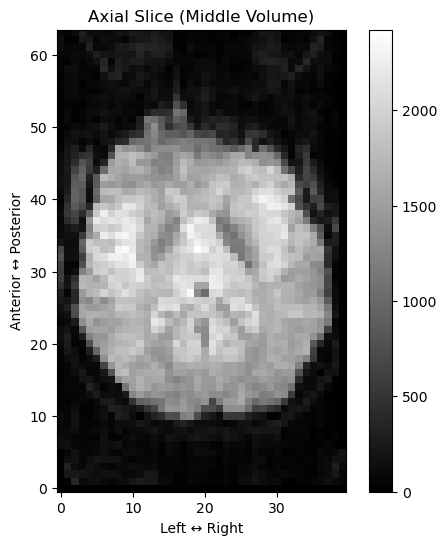

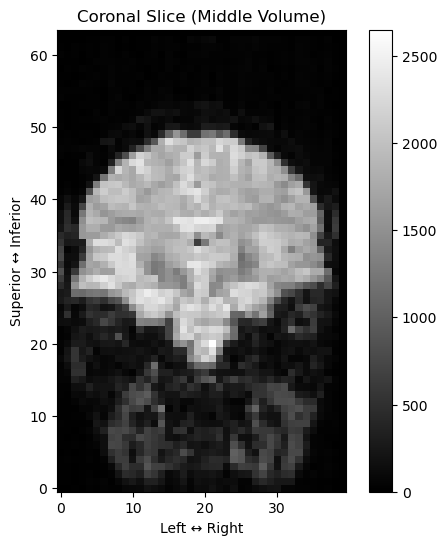

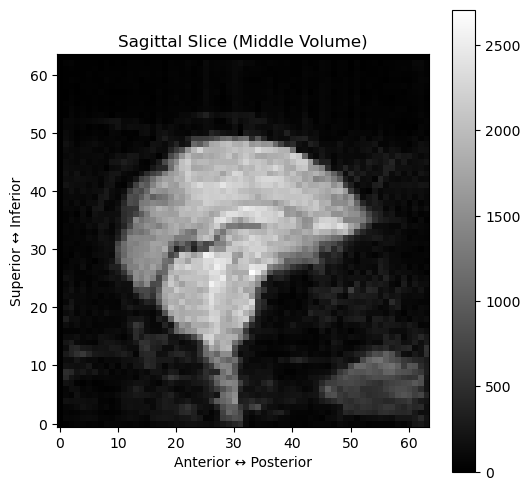

In [7]:
plot_fMRI_slice(bold_data, orientation="axial")
plot_fMRI_slice(bold_data, orientation="coronal")
plot_fMRI_slice(bold_data, orientation="sagittal")

In [8]:
def plot_voxel_time_series(bold_data, voxel_coords):
    """
    Extracts and plots time-course data for the selected voxels.

    Parameters:
        bold_data (numpy.ndarray): The 4D BOLD data with shape (X, Y, Z, T).
        voxel_coords (list of tuples): List of voxel coordinates (x, y, z).

    Returns:
        dict: A dictionary containing time-series data for each voxel.
    """
    time_series = {}

    # Set up the plot
    plt.figure(figsize=(12, 6))

    for x, y, z in voxel_coords:
        # Extract the time-course
        time_series[(x, y, z)] = bold_data[x, y, z, :]

        # Plot the time-course
        plt.plot(time_series[(x, y, z)], label=f'Voxel ({x}, {y}, {z})')

    # Add plot details
    plt.title("Time-Course Data for Selected Voxels")
    plt.xlabel("Time (Volumes)")
    plt.ylabel("Signal Intensity")
    plt.legend()
    plt.show()

    # Print mean and standard deviation of the signal for each voxel
    for coords, signal in time_series.items():
        print(f"Voxel {coords}: Mean={np.mean(signal):.2f}, Std={np.std(signal):.2f}")

    return time_series

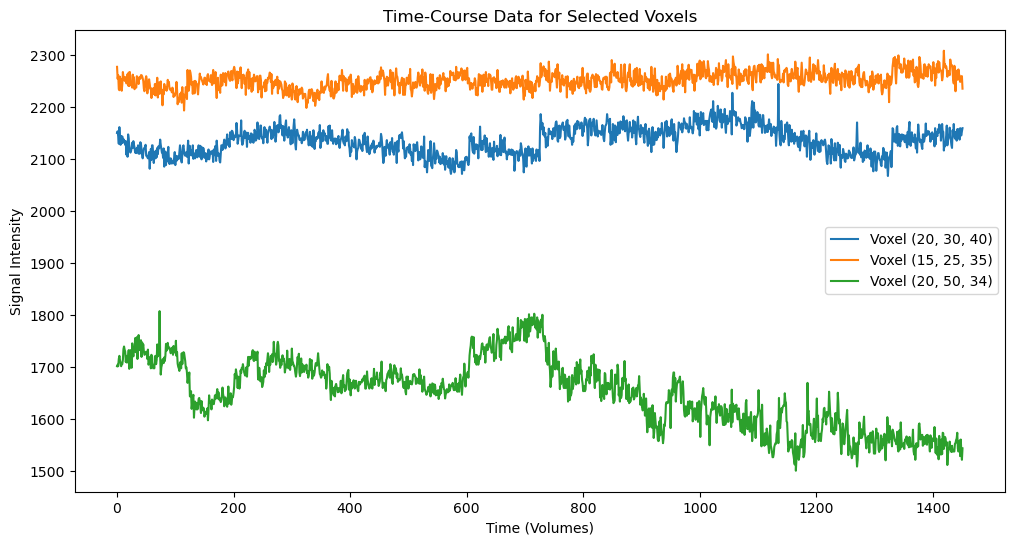

Voxel (20, 30, 40): Mean=2134.73, Std=25.94
Voxel (15, 25, 35): Mean=2251.22, Std=16.78
Voxel (20, 50, 34): Mean=1649.97, Std=65.61


In [9]:
voxel_coords = [(20, 30, 40), (15, 25, 35), (20, 50, 34)]
time_series = plot_voxel_time_series(bold_data, voxel_coords)

## Second Part: Design Matrix & Convolved Matrix

In [10]:
# Load and inspect labels.txt

# Load the labels into a pandas DataFrame
labels = pd.read_csv("subj1/labels.txt", sep=" ", header=0, names=["Condition", "Run"])

# Display the first few rows and shape
print(labels.head())
print(labels.shape)

  Condition  Run
0      rest    0
1      rest    0
2      rest    0
3      rest    0
4      rest    0
(1452, 2)


In [11]:
# Check unique conditions and their counts
print("Unique Conditions:", labels["Condition"].unique())

Unique Conditions: ['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']


In [12]:
print(labels["Condition"].value_counts())

Condition
rest            588
scissors        108
face            108
cat             108
shoe            108
house           108
scrambledpix    108
bottle          108
chair           108
Name: count, dtype: int64


In [13]:
print("Unique Runs:", labels["Run"].unique())

Unique Runs: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [14]:
def plot_conditions_over_time(labels):
    """
    Maps conditions to numeric values and plots them over time.

    Parameters:
        labels (pandas.DataFrame): A DataFrame containing a 'Condition' column.

    Returns:
        dict: A mapping of conditions to numeric values.
    """
    # Map conditions to numeric values for visualization
    condition_map = {condition: idx for idx, condition in enumerate(labels["Condition"].unique())}
    condition_numeric = labels["Condition"].map(condition_map)

    # Plot conditions over time
    plt.figure(figsize=(12, 6))
    plt.plot(condition_numeric, label="Stimulus Condition", linestyle="None", marker="o", markersize=2)
    plt.title("Stimuli Over Time")
    plt.xlabel("Time (Volumes)")
    plt.ylabel("Condition (Numeric)")
    plt.yticks(list(condition_map.values()), list(condition_map.keys()))
    plt.grid()
    plt.show()

    # Plot distribution of conditions across runs
    plt.figure(figsize=(12, 6))
    sns.histplot(data=labels, x="Run", hue="Condition", multiple="stack")
    plt.title("Distribution of Conditions Across Runs")
    plt.xlabel("Run")
    plt.ylabel("Count")
    plt.show()

    return condition_map

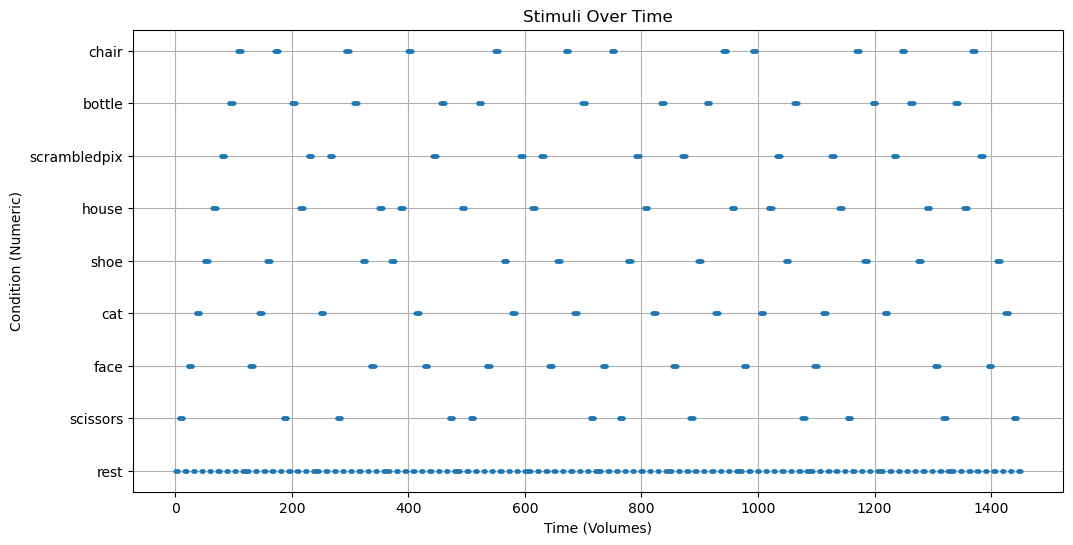

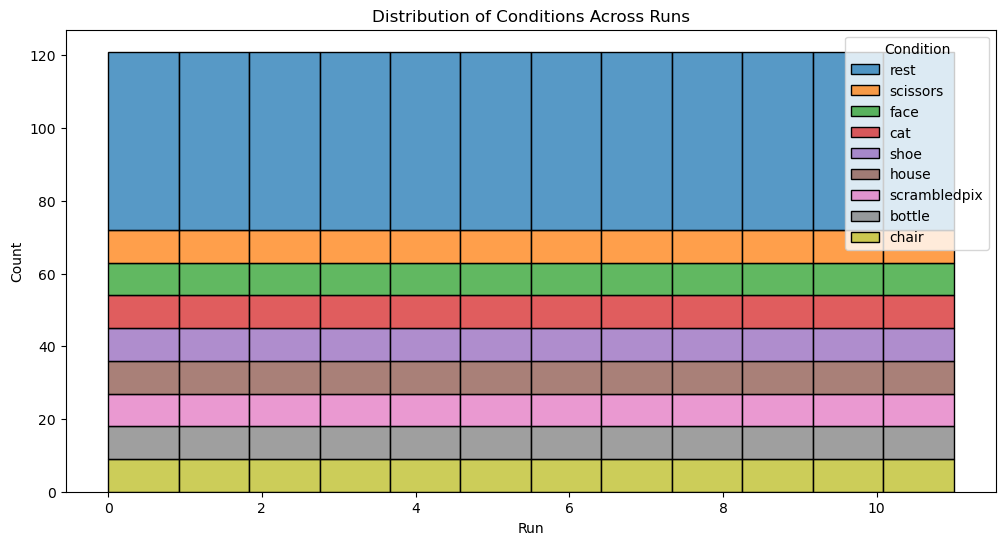

In [15]:
condition_map = plot_conditions_over_time(labels)

In [16]:
def create_design_matrix(labels):
    """
    Creates a design matrix from a labels DataFrame.

    Parameters:
        labels (pandas.DataFrame): A DataFrame containing 'Condition' and 'Run' columns.

    Returns:
        pandas.DataFrame: The design matrix with conditions as columns.
    """
    # Get unique conditions from labels
    unique_conditions = labels["Condition"].unique()

    # Initialize the design matrix
    design_matrix = pd.DataFrame(0, index=np.arange(len(labels)), columns=unique_conditions)

    # Fill the design matrix
    for condition in unique_conditions:
        design_matrix[condition] = (labels["Condition"] == condition).astype(int)

    # Drop the 'rest' condition
    if "rest" in design_matrix.columns:
        design_matrix = design_matrix.drop(columns=["rest"])
        #print("'rest' condition dropped from the design matrix.")

    return design_matrix

In [17]:
# Create the design matrix
design_matrix = create_design_matrix(labels)


# Display the first few rows and shape
#print(design_matrix.head())
#print(design_matrix.shape)

In [18]:
# Get unique conditions from labels
unique_conditions = [condition for condition in labels["Condition"].unique() if condition != "rest"]

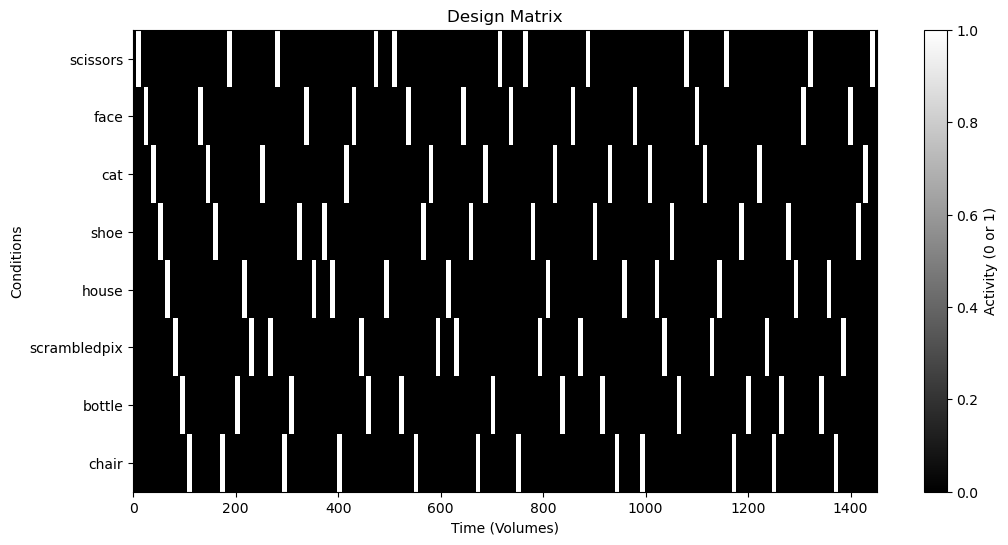

In [19]:
# Visualize the Design Matrix 
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.T, aspect="auto", cmap="gray", interpolation="nearest")
plt.title("Design Matrix")
plt.xlabel("Time (Volumes)")
plt.ylabel("Conditions")
plt.yticks(ticks=np.arange(len(unique_conditions)), labels=unique_conditions)
plt.colorbar(label="Activity (0 or 1)")
plt.show()

In [20]:
def add_run_intercepts(design_matrix, labels): 
    """
    Adds intercept columns for each run to the design matrix.

    Parameters:
        design_matrix (pd.DataFrame): Original design matrix (time points × conditions).
        labels (pd.DataFrame): DataFrame with 'Condition' and 'Run' columns.

    Returns:
        pd.DataFrame: Design matrix with added intercept columns.
    """
    design_matrix_with_intercepts = design_matrix.copy()
    unique_runs = labels["Run"].unique()

    # Add intercept columns
    for run in unique_runs:
        run_column_name = f"Run_{run}"
        design_matrix_with_intercepts[run_column_name] = (labels["Run"] == run).astype(int)

    return design_matrix_with_intercepts

In [21]:
# Modify the convolved matrix
design_matrix_with_intercepts  = add_run_intercepts(design_matrix, labels)

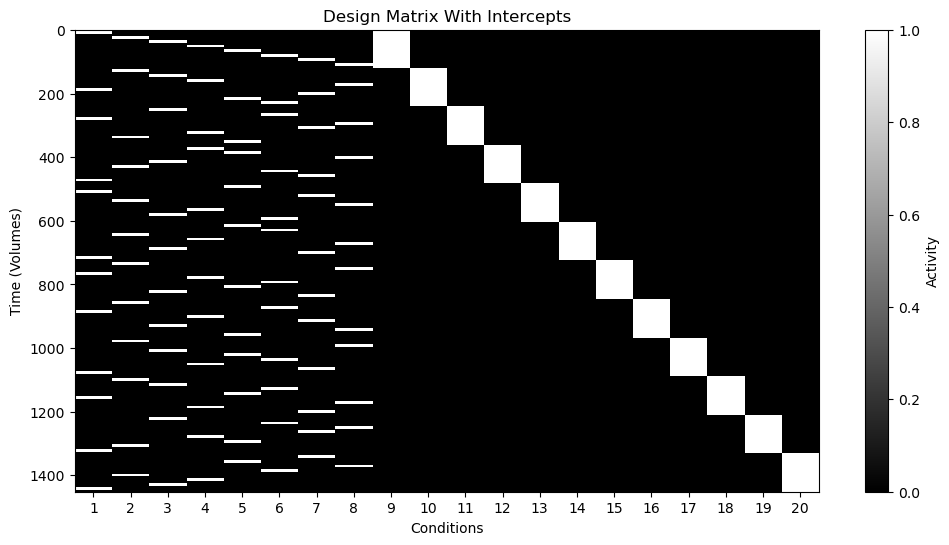

In [22]:
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix_with_intercepts, aspect="auto", cmap="gray", interpolation="nearest")
plt.title("Design Matrix With Intercepts")
plt.ylabel("Time (Volumes)")
plt.xlabel("Conditions")
plt.colorbar(label="Activity")

# Set x-axis ticks to integer values
num_conditions = design_matrix_with_intercepts.shape[1]
plt.xticks(ticks=np.arange(num_conditions), labels=np.arange(num_conditions) + 1)

plt.show()

In [23]:
# Load the HRF file
hrf_path = "hrf.mat"  
hrf_data = loadmat(hrf_path)

# Inspect the contents of the .mat file
#print(hrf_data.keys())

In [24]:
hrf_highres = hrf_data.get("hrf_highres", None).flatten()  # High-resolution HRF
hrf_sampled = hrf_data.get("hrf_sampled", None).flatten()  # Downsampled HRF

High-resolution HRF shape: (321,)
Sampled HRF shape: (13,)


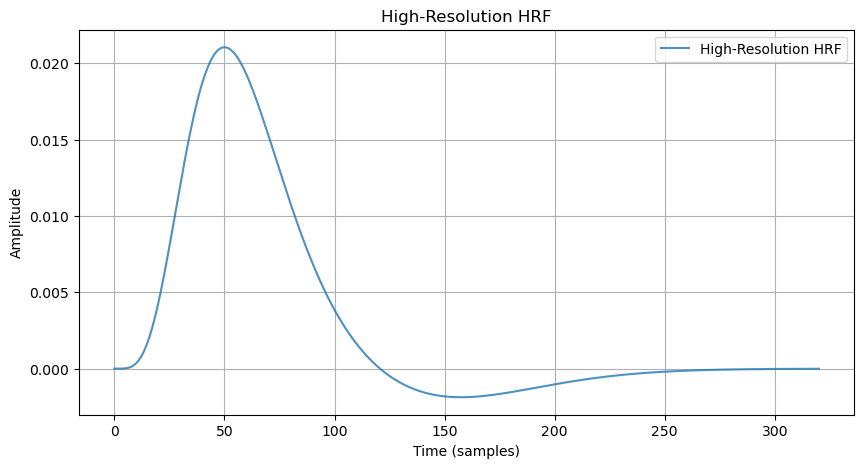

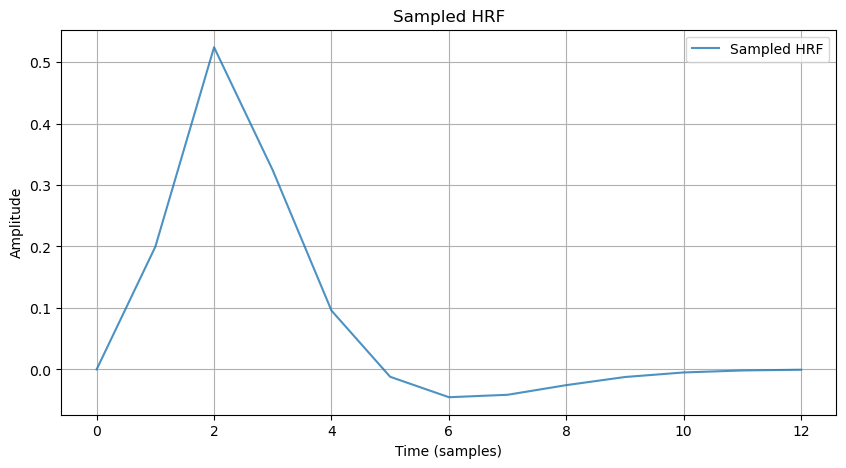

In [25]:
# Check and visualize the HRFs
print(f"High-resolution HRF shape: {hrf_highres.shape}")
print(f"Sampled HRF shape: {hrf_sampled.shape}")

# Plot the HRFs
plt.figure(figsize=(10, 5))
plt.plot(hrf_highres, label="High-Resolution HRF", alpha=0.8)
plt.title("High-Resolution HRF")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

# Plot the HRFs
plt.figure(figsize=(10, 5))
plt.plot(hrf_sampled, label="Sampled HRF", alpha=0.8)
plt.title("Sampled HRF")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [26]:
def convolve_conditions(design_matrix, hrf_sampled):
    """
    Convolves only the condition columns of the design matrix with the HRF.

    Parameters:
        design_matrix (pd.DataFrame): Design matrix with conditions and intercepts.
        hrf_sampled (numpy.ndarray): The sampled HRF.

    Returns:
        pd.DataFrame: Design matrix with convolved conditions and unmodified intercepts.
    """
    # Identify condition columns (non-intercept)
    condition_columns = [col for col in design_matrix.columns if not col.startswith("Run")]
    intercept_columns = [col for col in design_matrix.columns if col.startswith("Run")]

    # Initialize the convolved matrix
    convolved_matrix = pd.DataFrame(index=design_matrix.index)

    # Convolve conditions
    for condition in condition_columns:
        convolved_signal = np.convolve(design_matrix[condition], hrf_sampled, mode="full")[:len(design_matrix)]
        convolved_matrix[condition] = convolved_signal

    # Add intercept columns without modification
    for intercept in intercept_columns:
        convolved_matrix[intercept] = design_matrix[intercept]

    return convolved_matrix

In [27]:
#print(convolved_matrix.mean(axis=0))
#print(convolved_matrix.std(axis=0))

In [28]:
convolved_matrix = convolve_conditions(design_matrix_with_intercepts, hrf_sampled)
#print(convolved_matrix.head())
assert bold_data.shape[-1] == convolved_matrix.shape[0], "Mismatch between BOLD volumes and design matrix rows."

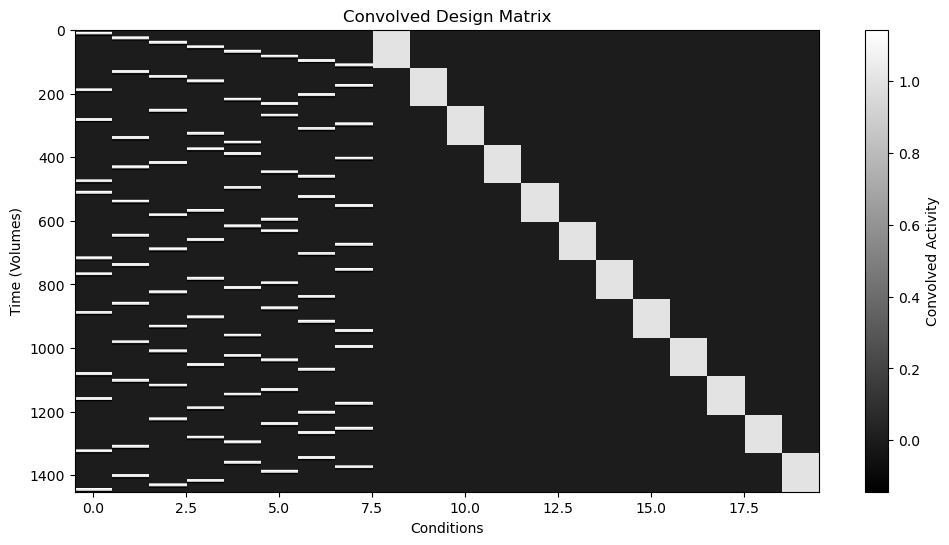

In [29]:
# Visualize the Convolved Matrix

plt.figure(figsize=(12, 6))
plt.imshow(convolved_matrix, aspect="auto", cmap="gray", interpolation="nearest")
plt.title("Convolved Design Matrix")
plt.xlabel("Conditions")
plt.ylabel("Time (Volumes)")
plt.colorbar(label="Convolved Activity")
plt.show()

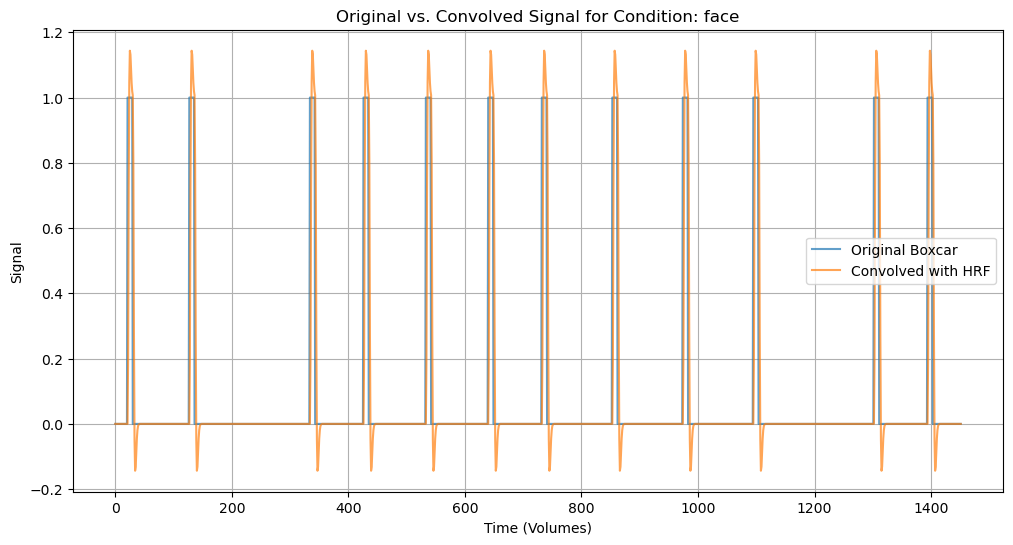

In [30]:
# Select a condition (e.g., "face") for comparison
condition = "face"

plt.figure(figsize=(12, 6))
plt.plot(design_matrix[condition], label="Original Boxcar", alpha=0.7)
plt.plot(convolved_matrix[condition], label="Convolved with HRF", alpha=0.7)
plt.title(f"Original vs. Convolved Signal for Condition: {condition}")
plt.xlabel("Time (Volumes)")
plt.ylabel("Signal")
plt.legend()
plt.grid()
plt.show()

## Third Part: GLM and Beta Maps

In [31]:
def fit_glm_and_generate_beta_maps(bold_data, X):
    """
    Fits a General Linear Model (GLM) voxel-by-voxel and generates beta coefficient maps.

    Parameters:
        bold_data (numpy.ndarray): The 4D BOLD fMRI data with shape (X, Y, Z, Time).
        X (pandas.DataFrame): The convolved design matrix.

    Returns:
        numpy.ndarray: Beta coefficient maps with shape (X, Y, Z, N_conditions).
    """
    # Reshape the fMRI data for voxel-wise analysis
    Y = bold_data.reshape(-1, bold_data.shape[-1]).T  # Shape: (Time, Voxels)
    #print(f"fMRI data reshaped to: {Y.shape}")

    # Ensure the design matrix is aligned with the fMRI data
    assert Y.shape[0] == X.shape[0], "Mismatch in time points!"

    # Solve the GLM
    X_pinv = np.linalg.pinv(X)  # Use pseudo-inverse for stability
    beta_matrix = X_pinv @ Y

    
    # Compute residuals (optional, for model evaluation)
    residuals = Y - (X @ beta_matrix)  # Shape: (Time, N_voxels)

    # Reshape beta coefficients back to brain space
    beta_maps = beta_matrix.T.reshape(bold_data.shape[:-1] + (X.shape[1],))  # Shape: (X, Y, Z, N_conditions)

    return residuals, beta_maps


In [32]:
# load design matrix as "convolved_matrix"
X = convolved_matrix.values
df = X.shape[0] - np.linalg.matrix_rank(X)

In [33]:
# Fit the GLM and get results
residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, X)

In [49]:
def visualize_beta_map(beta_maps, convolved_matrix, condition_name, slice_idx=None):
    """
    Visualizes the beta map for a specified condition with optional slice selection and thresholding.

    Parameters:
        beta_maps (numpy.ndarray): Beta coefficient maps with shape (X, Y, Z, N_conditions).
        convolved_matrix (pandas.DataFrame): The convolved design matrix.
        condition_name (str): The name of the condition to visualize.
        slice_idx (int, optional): The z-dimension slice index to visualize. Defaults to the middle slice.

    Raises:
        ValueError: If the specified condition is not found in the design matrix.
    """
    # Find the column index for the specified condition
    if condition_name not in convolved_matrix.columns:
        raise ValueError(f"Condition '{condition_name}' not found in the design matrix.")
    
    condition_idx = list(convolved_matrix.columns).index(condition_name)

    # Default to middle slice if slice_idx is not provided
    if slice_idx is None:
        slice_idx = beta_maps.shape[2] // 2

    # Extract the beta map for the specified condition and slice
    beta_map_slice = beta_maps[:, :, slice_idx, condition_idx]

    # Apply thresholding
    threshold = 0
    #beta_map_slice = np.where(np.abs(beta_map_slice) < threshold, 0, beta_map_slice)

    # Visualize the beta map
    plt.figure(figsize=(8, 8))
    plt.imshow(beta_map_slice.T, cmap="coolwarm", origin="lower", vmin=-30, vmax=30)
    plt.title(f"Beta Map for Condition: {condition_name} (Slice {slice_idx}, Threshold {threshold})")
    plt.colorbar(label="Beta Value")
    plt.xlabel("X-axis (Left ↔ Right)")
    plt.ylabel("Y-axis (Anterior ↔ Posterior)")
    plt.show()


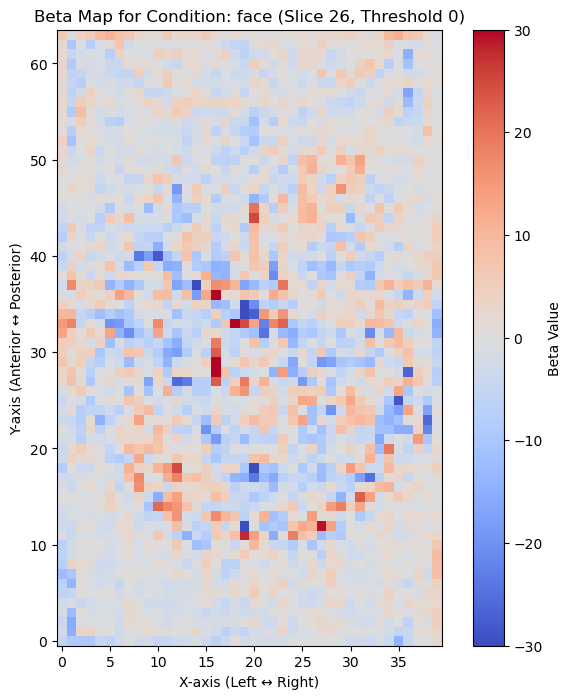

In [50]:
visualize_beta_map(beta_maps, convolved_matrix, "face", slice_idx=26)

In [51]:
def visualize_beta_map_grid(beta_maps, convolved_matrix, condition_name, slice_range=None, slices_per_row=7):
    """
    Visualizes beta maps for a specified condition in a grid layout.

    Parameters:
        beta_maps (numpy.ndarray): Beta coefficient maps with shape (X, Y, Z, N_conditions).
        convolved_matrix (pandas.DataFrame): The convolved design matrix.
        condition_name (str): The name of the condition to visualize.
        slice_range (list, optional): A list of z-dimension slice indices to visualize. Defaults to all slices.
        slices_per_row (int): Number of slices to display per row. Defaults to 7.

    Raises:
        ValueError: If the specified condition is not found in the design matrix.
    """
    
    # Validate the condition
    if condition_name not in convolved_matrix.columns:
        raise ValueError(f"Condition '{condition_name}' not found in the design matrix.")
    
    condition_idx = convolved_matrix.columns.get_loc(condition_name)

    # Set the slice range to all slices if not specified
    if slice_range is None:
        slice_range = range(beta_maps.shape[2])

    # Determine grid size
    n_slices = len(slice_range)
    n_rows = int(np.ceil(n_slices / slices_per_row))

    # Initialize the plot
    fig, axes = plt.subplots(n_rows, slices_per_row, 
                              figsize=(slices_per_row * 2, n_rows * 2), 
                              constrained_layout=True)

    axes = axes.flatten()  # Flatten for easy indexing

    # Plot each slice
    for i, slice_idx in enumerate(slice_range):
        if i >= len(axes):
            break

        # Extract the beta map for the current slice and condition
        beta_map_slice = beta_maps[:, :, slice_idx, condition_idx]

        # Display the beta map
        im = axes[i].imshow(beta_map_slice, cmap="coolwarm", origin="lower", vmin=-10, vmax=10)
        axes[i].axis("off")

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Add a single shared colorbar
    fig.colorbar(im, ax=axes[:n_slices], orientation="vertical", fraction=0.02, pad=0.04, label="Beta Value")

    # Add a title
    fig.suptitle(f"Beta Maps for Condition: {condition_name}", fontsize=14)
    plt.show()


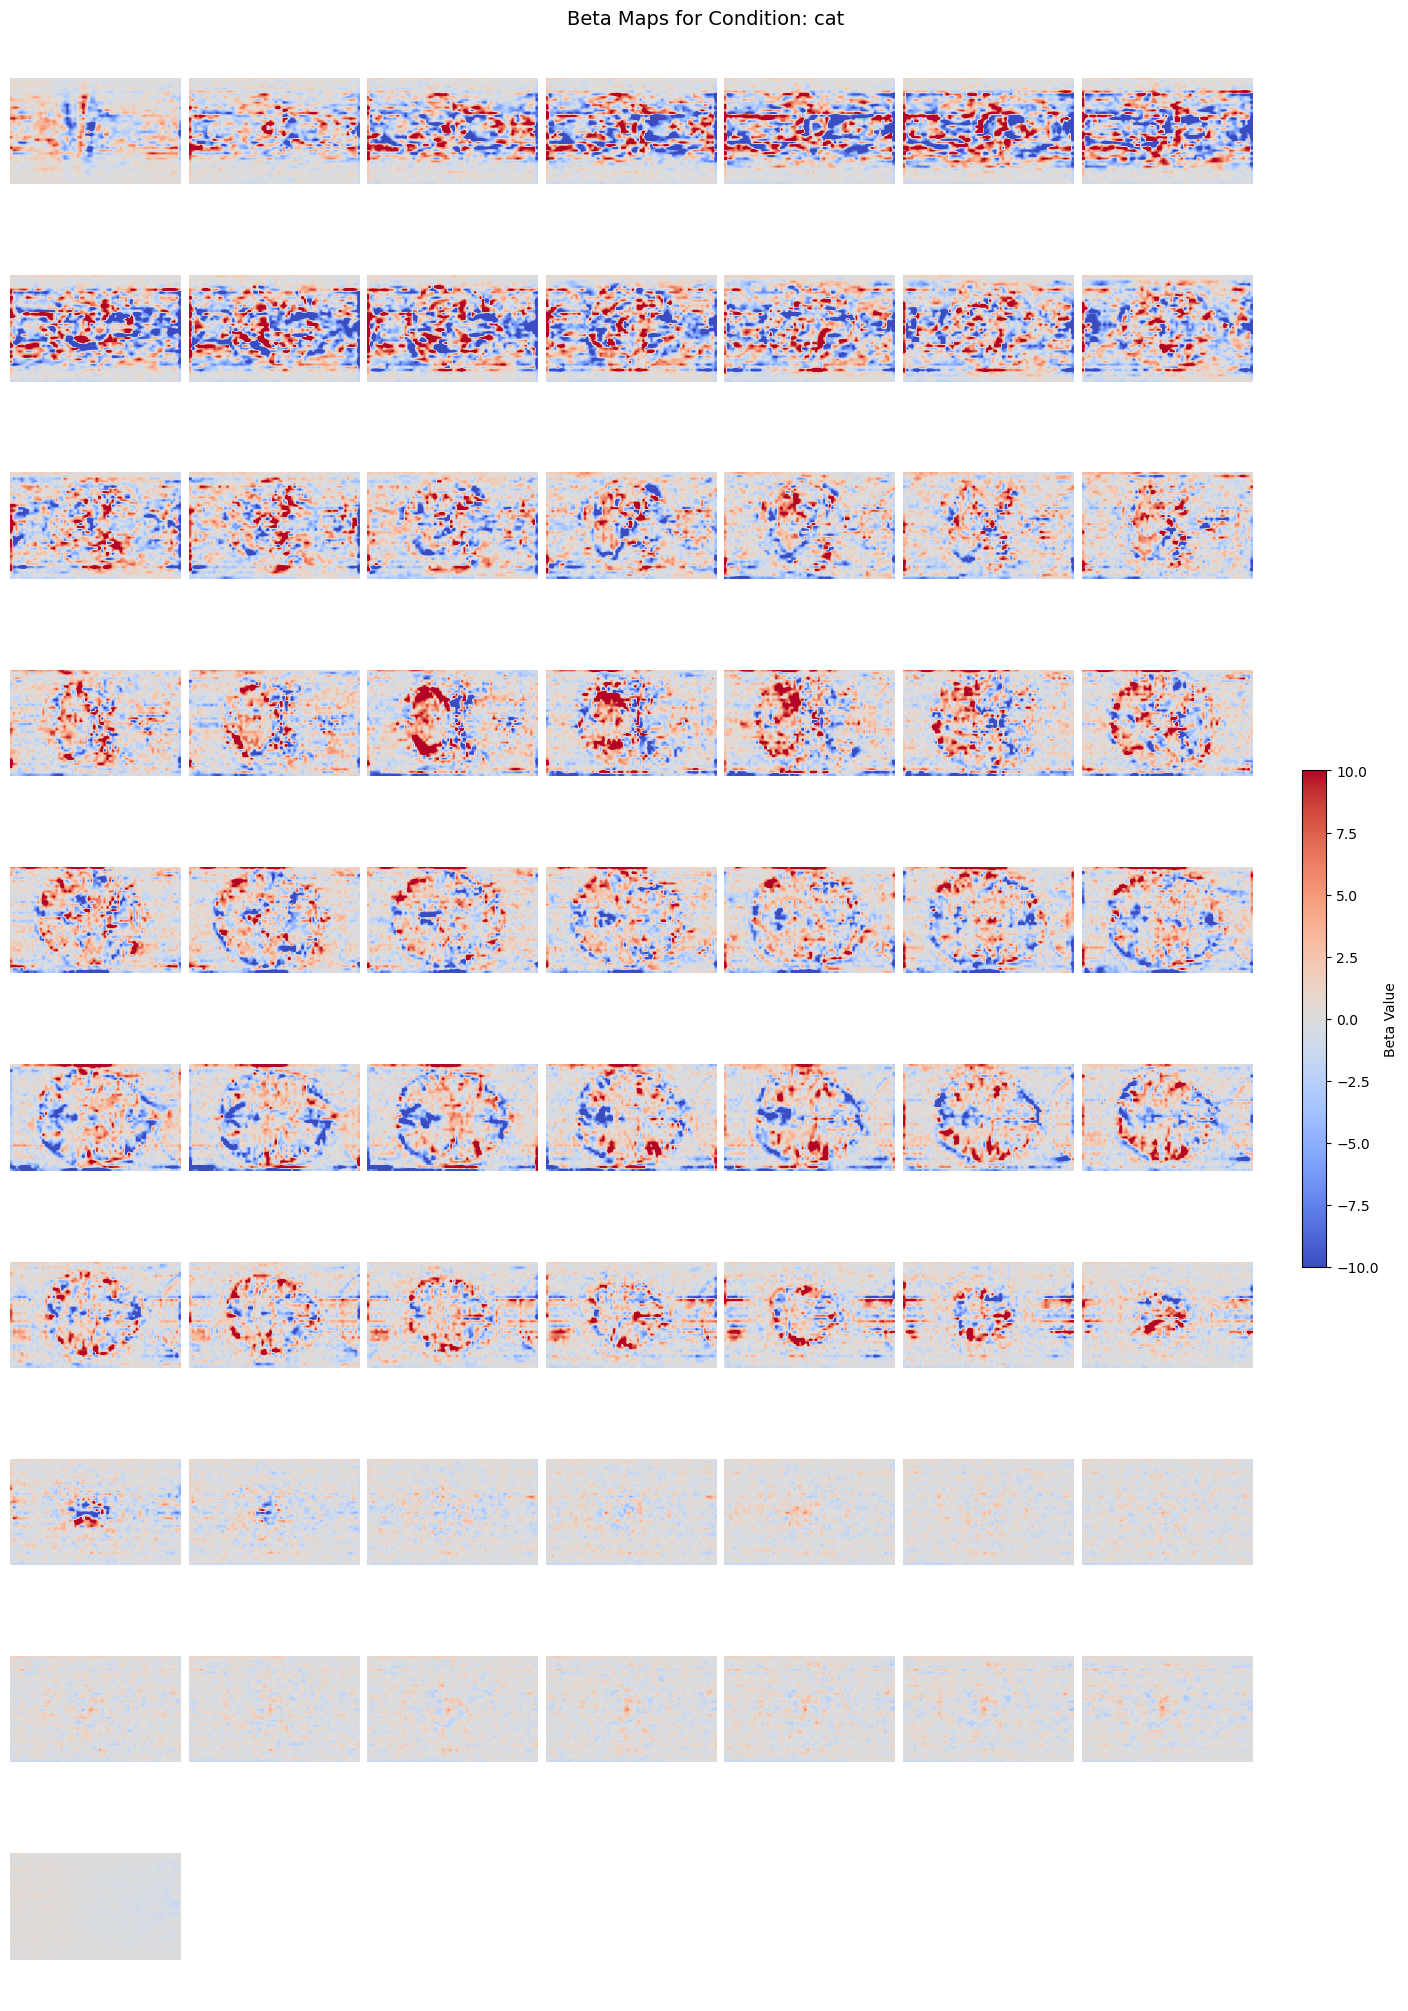

In [52]:
# Visualize all slices for the "cat" condition
visualize_beta_map_grid(beta_maps, convolved_matrix, "cat")

## Fourth Part: T-maps & Bonferroni Correction

In [53]:
def compute_t_values(beta_maps, design_matrix, residuals, df, mask=None, variance_threshold=1e-12, epsilon=1e-10):
    """
    Computes t-values for beta maps and residuals.

    Parameters
    ----------
    beta_maps : np.ndarray
        4D array of beta coefficients, shape (X, Y, Z, N_conditions).
    design_matrix : pd.DataFrame
        Design matrix, shape (time_points, N_conditions).
    residuals : np.ndarray
        Residuals, shape (time_points, N_voxels).
    df : int
        Degrees of freedom (time_points - rank(X)).
    mask : np.ndarray, optional
        Boolean array (X, Y, Z). Restricts computations if provided.
    variance_threshold : float, optional
        Minimum residual variance threshold.
    epsilon : float, optional
        Small value to avoid division by zero.

    Returns
    -------
    t_maps : np.ndarray
        4D array of t-values, shape (X, Y, Z, N_conditions).
    """
    X = design_matrix.values
    X_pinv = np.linalg.pinv(X)
    diag_cov = np.diag(X_pinv @ X_pinv.T).astype(float)

    # Handle zero values in diag_cov
    diag_cov = np.maximum(diag_cov, epsilon)
    # diag_cov = np.diag(np.linalg.pinv(design_matrix.values.T @ design_matrix.values))

    n_time_points, n_regressors = X.shape
    X_size, Y_size, Z_size, n_conditions = beta_maps.shape
    assert n_regressors == n_conditions, "Mismatch between design matrix and beta maps."

    beta_reshaped = beta_maps.reshape(-1, n_conditions)
    n_voxels = X_size * Y_size * Z_size
    assert residuals.shape == (n_time_points, n_voxels), "Residuals shape mismatch."

    if mask is not None:
        assert mask.shape == (X_size, Y_size, Z_size), "Invalid mask shape."
        mask_indices = np.where(mask.flatten())
        beta_reshaped = beta_reshaped[mask_indices]
        residuals = residuals[:, mask_indices[0]]
    else:
        mask_indices = None

    residual_var = np.sum(residuals**2, axis=0) / df
    residual_var = np.maximum(residual_var, variance_threshold)

    # Ensure residual_var is a NumPy array
    residual_var = np.asarray(residual_var)

    # Compute standard errors and enforce epsilon for safety
    SE = np.sqrt(residual_var[:, np.newaxis] * diag_cov)
    SE = np.maximum(SE, epsilon)

    # Compute t-values
    t_values = beta_reshaped / SE

    # Reconstruct t-maps
    t_maps = np.zeros((X_size, Y_size, Z_size, n_conditions), dtype=np.float32)
    if mask is not None:
        t_maps_flat = t_maps.reshape(-1, n_conditions)
        t_maps_flat[mask_indices] = t_values
        t_maps = t_maps_flat.reshape(X_size, Y_size, Z_size, n_conditions)
    else:
        t_maps = t_values.reshape(X_size, Y_size, Z_size, n_conditions)

    return t_maps


In [54]:
def visualize_t_map(t_maps, design_matrix, condition_name,
                            slice_idx=None, cmap="bwr", vmin=-10, vmax=10):
    """
    Visualizes the t-map for a specified condition. If slice_idx is None,
    use the middle slice. 

    Parameters
    ----------
    t_maps : np.ndarray
        4D array of t-values, shape (X, Y, Z, N_conditions).
    design_matrix : pd.DataFrame
        The design matrix (to find condition_name index).
    condition_name : str
        The condition to visualize (must be a column in the design matrix).
    slice_idx : int or None
        Which z-slice to display. Defaults to the middle.
    """
    if condition_name not in design_matrix.columns:
        raise ValueError(f"Condition '{condition_name}' not found in the design matrix columns.")

    condition_idx = list(design_matrix.columns).index(condition_name)
    X_size, Y_size, Z_size, n_conditions = t_maps.shape

    if slice_idx is None:
        slice_idx = Z_size // 2  # middle slice

    # Extract 2D slice for the chosen condition
    t_slice = t_maps[:, :, slice_idx, condition_idx]

    plt.figure(figsize=(6, 5))
    plt.imshow(t_slice, cmap=cmap, origin="lower", vmin=vmin, vmax=vmax)
    plt.colorbar(label="t-value")
    plt.title(f"T-Map for Condition: {condition_name}\nSlice {slice_idx}")
    plt.axis("off")
    plt.show()

In [55]:
# Compute T-Maps (full volume or masked)
mask_path = "subj1/mask4_vt.nii.gz"
mask_data = nib.load(mask_path).get_fdata()  
mask_bool = (mask_data > 0)

In [63]:
# Full volume
t_maps = compute_t_values(
    beta_maps=beta_maps,
    design_matrix=convolved_matrix,
    residuals=residuals,
    df=df,
    mask= None   # None or mask_bool
)

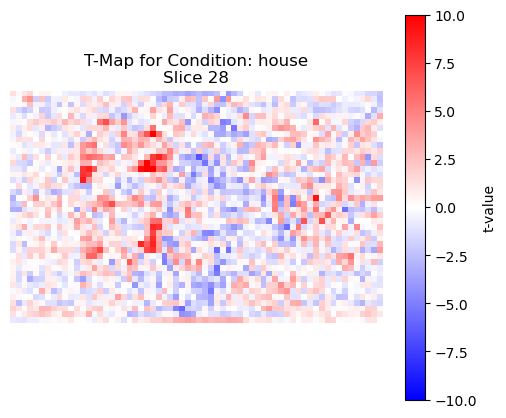

In [59]:
# Visualize a condition
visualize_t_map(t_maps, convolved_matrix, condition_name="house", slice_idx=28)

In [60]:
def overlay_t_map_on_fmri(fmri_data, t_map, slice_idx, condition_name, alpha=0.5, cmap="coolwarm"):
    """
    Overlays a t-map on top of fMRI data for a specific slice with improved clarity.

    Parameters:
        fmri_data (numpy.ndarray): The 4D fMRI data (X, Y, Z, Time).
        t_map (numpy.ndarray): The full-brain t-map (X, Y, Z).
        slice_idx (int): The index of the z-dimension slice to visualize.
        condition_name (str): The name of the condition for the t-map.
        alpha (float, optional): Opacity for the t-map overlay. Default is 0.5.
        cmap (str, optional): Colormap for the t-map. Default is "coolwarm".
    """
    if slice_idx < 0 or slice_idx >= fmri_data.shape[2]:
        raise ValueError(f"Invalid slice index {slice_idx}. Must be between 0 and {fmri_data.shape[2] - 1}.")

    # Extract the anatomical slice from the fMRI data (mean across time for visualization)
    fmri_slice = fmri_data[:, slice_idx, :, :].mean(axis=-1)

    # Normalize and apply gamma correction
    fmri_slice = (fmri_slice - fmri_slice.min()) / (fmri_slice.max() - fmri_slice.min())
    gamma = 0.5
    fmri_slice = np.power(fmri_slice, gamma)

    # Extract the corresponding t-map slice and apply thresholding
    t_map_slice = t_map[:, :, slice_idx]
    threshold = 2.0
    t_map_slice = np.where(np.abs(t_map_slice) < threshold, 0, t_map_slice)

    # Plot the overlay
    plt.figure(figsize=(8, 8))
    plt.imshow(fmri_slice.T, cmap="gray", origin="lower")
    plt.imshow(t_map_slice.T, cmap=cmap, alpha=alpha, origin="lower")
    plt.colorbar(label="t-value")
    plt.title(f"Overlay of T-Map and fMRI Data (Slice {slice_idx})\nCondition: {condition_name}")
    plt.xlabel("X-axis (Left ↔ Right)")
    plt.ylabel("Y-axis (Anterior ↔ Posterior)")
    plt.show()


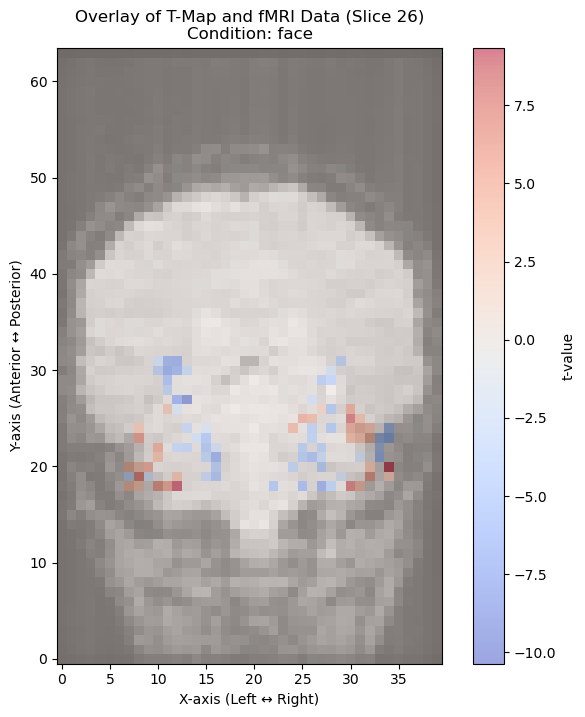

In [62]:
condition_name = "face"
condition_idx = list(convolved_matrix.columns).index(condition_name)

# Extract the t-map for the desired condition
t_map = t_maps[:, :, :, condition_idx]

# Overlay the t-map with the fMRI data for a middle slice
overlay_t_map_on_fmri(bold_data, t_map, slice_idx=26, condition_name=condition_name)

In [64]:
def apply_bonferroni_correction(t_maps, df, mask_bool, alpha=0.05):
    """
    Applies Bonferroni correction to T-maps.

    Parameters:
        t_maps (numpy.ndarray): Full-brain T-maps with shape (X, Y, Z, N_conditions).
        df (int): Degrees of freedom (time points - rank(X)).
        mask_bool (numpy.ndarray): Boolean mask for the region of interest (ROI).
        alpha (float, optional): Desired family-wise error rate (default: 0.05).

    Returns:
        numpy.ndarray: Corrected T-maps with non-significant values set to 0.
    """
    # Number of tests (voxels in the mask)
    n_tests = np.sum(mask_bool)
    #print(f"Number of tests (voxels): {n_tests}")

    # Adjusted p-value threshold using Bonferroni correction
    adjusted_alpha = alpha / n_tests
    #print(f"Bonferroni-adjusted alpha: {adjusted_alpha}")

    # Convert the adjusted alpha to a T-value threshold
    t_threshold = t.ppf(1 - adjusted_alpha / 2, df)  # Two-tailed
    #print(f"Bonferroni T-value threshold: {t_threshold}")

    # Mask the T-maps with the Bonferroni threshold
    corrected_t_maps = np.zeros_like(t_maps)
    significant_mask = np.abs(t_maps) > t_threshold  # Significant voxels
    corrected_t_maps[significant_mask] = t_maps[significant_mask]

    return corrected_t_maps

In [46]:
# Apply Bonferroni correction
alpha = 0.05  # Family-wise error rate
corrected_t_maps = apply_bonferroni_correction(t_maps, df, mask_bool, alpha)

# Visualize the corrected T-map for a specific condition
condition_name = "face"
condition_idx = list(convolved_matrix.columns).index(condition_name)
#overlay_t_map_on_fmri(bold_data, corrected_t_maps[:, :, :, condition_idx], slice_idx=24, condition_name=condition_name)

### Fifth Part: Convolved Matrix with Trends

In [65]:
def create_convolved_matrix_with_trends(design_matrix, max_degree=2):
    """
    Creates a convolved design matrix by convolving each condition with the HRF and adds constant terms
    and polynomial trends for high-pass filtering.

    Parameters:
        design_matrix (pandas.DataFrame): The original design matrix with conditions as columns.
        hrf_sampled (numpy.ndarray): The sampled hemodynamic response function (HRF).
        max_degree (int, optional): The maximum degree of polynomial trends to include. Default is 2 (linear and quadratic).

    Returns:
        pandas.DataFrame: The enhanced convolved design matrix.
    """
    # Add constant term (intercept)
    #convolved_matrix['constant'] = 1

    # Add polynomial trends
    time = np.arange(len(design_matrix))
    for degree in range(1, max_degree + 1):
        trend_name = f"poly_{degree}"
        design_matrix[trend_name] = (time**degree - (time**degree).mean()) / (time**degree).std()

    return design_matrix

In [66]:
# Create the convolved design matrix with constant terms and trends
convolved_matrix_trends = create_convolved_matrix_with_trends(convolved_matrix)

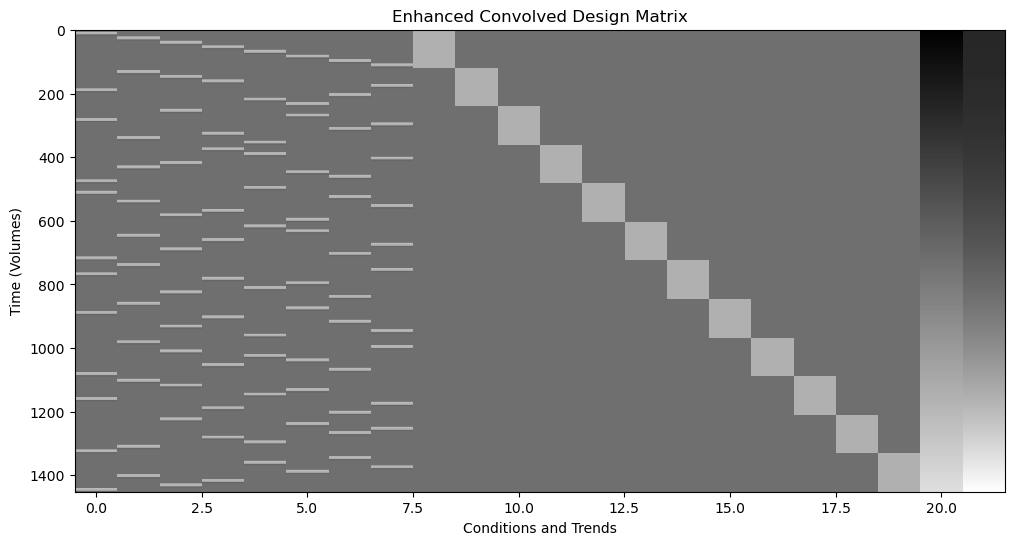

In [67]:
plt.figure(figsize=(12, 6))
plt.imshow(convolved_matrix_trends, aspect="auto", cmap="gray", interpolation="nearest")
plt.title("Enhanced Convolved Design Matrix")
plt.xlabel("Conditions and Trends")
plt.ylabel("Time (Volumes)")
plt.show()